In [1]:
import torch
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cmasher as cmr
%matplotlib inline
plt.style.use('default')
plt.rcParams.update({'font.size': 12})

In [2]:
def crps(mu: torch.Tensor,sigma: torch.tensor, y: torch.Tensor) -> torch.Tensor:
    """Calculates the Continuous Ranked Probability Score (CRPS) assuming normally distributed df

    :param torch.Tensor mu: tensor of mean
    :param torch.Tensor mu: tensor of standard deviation
    :param torch.Tensor y: observed df

    :return tensor: CRPS value
    :rtype torch.Tensor
    """
    y = y.view((-1,1)) # make sure y has the right shape
    pi = np.pi #3.14159265359
    omega = (y - mu) / sigma
    # PDF of normal distribution at omega
    pdf = 1/(torch.sqrt(torch.tensor(2 * pi))) * torch.exp(-0.5 * omega ** 2)

    # Source: https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related
    cdf = 0.5 * (1 + torch.erf(omega / torch.sqrt(torch.tensor(2))))

    crps_score = sigma * (omega * (2 * cdf - 1) + 2 * pdf - 1/torch.sqrt(torch.tensor(pi)))
    return  crps_score

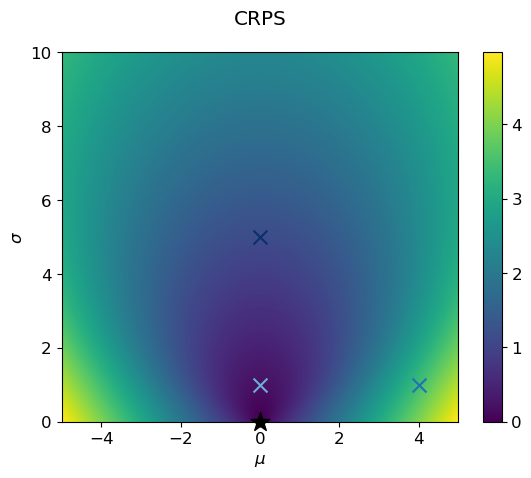

In [21]:
# Define the range of mu and sigma
mu_range = torch.linspace(-5, 5, 100)
sigma_range = torch.linspace(0, 10, 100) + 1e-16

mu_grid, sigma_grid = torch.meshgrid(mu_range, sigma_range)

# Fix the value of y to 0 (1x1 tensor)
y = torch.tensor([0])

# Evaluate the function for each combination of mu and sigma
z = crps(mu_grid, sigma_grid, y)

# Convert the tensors to numpy arrays for plotting
mu_np = mu_range.numpy()
sigma_np = sigma_range.numpy()
z_np = z.numpy() - np.min(z.numpy())

# Create the contour plot
plt.figure()
contour_plot = plt.contourf(mu_np, sigma_np, z_np.T, levels=1000, cmap="viridis")

for c in contour_plot.collections:
    c.set_edgecolor("face")

colorbar = plt.colorbar(contour_plot)
colorbar.set_ticks([0, 1, 2, 3, 4])
# Examples
ex = [[0,5],[4,1],[0,1]]

cmap = matplotlib.colormaps['Blues_r']
colors = [cmap(i) for i in np.linspace(0, 0.5, len(ex))]
for (mu,sigma), col in zip(ex, colors):
    plt.scatter([mu],[sigma], marker='x', color=col, s=100)
plt.scatter([0],0, color='black', marker='*', zorder=10, clip_on=False, s=200)

plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
plt.title('$\operatorname{CRPS}$', pad=20)
plt.savefig("plots/crps_contour.pdf", format="pdf", dpi=600, bbox_inches='tight')

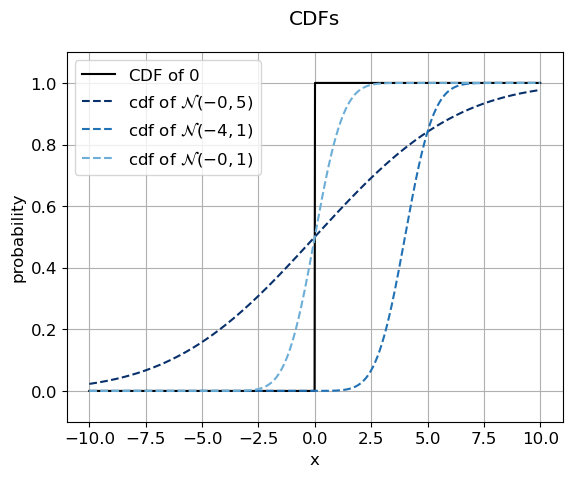

In [22]:
# Create an array of x values from -10 to 10 (adjust the range as needed)
x = np.linspace(-10, 10, 1000)

# Calculate the CDF of the random variable fixed at 0
step_cdf = np.where(x >= 0, 1, 0)

# Plot both CDFs and the colored space between them
plt.plot(x, step_cdf, label='CDF of $0$', color='black')

for (mu, sigma), col in zip(ex, colors):
    cdf = dist.Normal(mu, sigma).cdf(torch.tensor(x))
    lab = r'cdf of $\mathcal{N}$' + f'$(-{mu},{sigma})$'
    plt.plot(x, cdf, label=lab, linestyle='--', color=col)


plt.title('CDFs', pad=20)
plt.xlabel('x')
plt.ylabel('probability')
plt.ylim(-0.1, 1.1)  # Adjust the y-axis limits to fit the step function
plt.grid()
plt.legend()
plt.savefig("plots/crps_example_cdfs.pdf", format="pdf", dpi=600, bbox_inches='tight')

In [33]:
# Calculation of integral of squared errors
abs_diff_cdf = (normal_cdf - step_cdf)**2
# Calculate the area using the trapezoidal rule
area = np.trapz(abs_diff_cdf, x=x)
print(area)
print(crps(mu=torch.Tensor([1]), sigma=torch.Tensor([3]), y=torch.Tensor([0])))

0.8328429104037658
tensor([[0.8328]])
